In [1]:
import torch
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from torch.utils.data import Dataset, DataLoader, TensorDataset

from google.colab import auth
from google.colab import drive

auth.authenticate_user()
drive.mount('/content/gdrive')
PATH = '/content/gdrive/My Drive/dataset/'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


''''''
BATCH_SIZE = 20
EPOCHS = 200
NUM = 3001
lr = 2*10e-5
''''''

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


''

In [2]:


def dB( magnitude ):

    decibel = 20*np.log10( np.abs(magnitude) + np.finfo(float).eps )    
    return decibel




def normalization( L, R ):

    LR = np.asarray( [ L, R ] )
    mu = np.mean( LR )
    sigma = np.std( LR )
    z = ( LR - mu ) / sigma
    
    return z[0], z[1]



from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler



def scaler( L, R):
    LR = np.concatenate( (L,R), axis=0 )
    #z = MinMaxScaler().fit_transform(LR[:])
    z = StandardScaler().fit_transform(LR[:])
    #z = RobustScaler().fit_transform(LR[:])
    #z = MaxAbsScaler().fit_transform(LR[:])
    z = z.reshape(2, 257, 382)
    return z[0], z[1]




def angle_to_digit( y_data ):
    
    for idx in range(y_data.shape[0]):
        
        y = y_data[idx]
        if y<0: y_data[idx] = 10
        else:   y_data[idx] = ( y//20 )
    
    return y_data



In [3]:


x_data = ['S_left.npy', 'S_right.npy', 'S_left_phase.npy','S_right_phase.npy']
y_data = np.load(PATH+ 'angle.npy')


S_left  = np.load( PATH + x_data[0] )
S_right = np.load( PATH + x_data[1] )
S_left_phase  = np.load( PATH + x_data[2] )
S_right_phase = np.load( PATH + x_data[3] )

    

In [4]:


x_data = []

for idx in range( y_data.shape[0] ):
    
    x_element = []
    
    mag_L = S_left[:,:,idx]
    mag_R = S_right[:,:,idx]
    phi_L = S_left_phase[:,:,idx]
    phi_R = S_right_phase[:,:,idx]


    """log[dB] scale"""
    log_L = dB( mag_L )
    log_R = dB( mag_R )


    """정규화"""
    #z_mag = normalization( log_L, log_R )
    #z_phi = normalization( phi_L, phi_R )

    z_mag = scaler( log_L, log_R )
    z_phi = scaler( phi_L, phi_R )
    
    x_left_mag ,  x_right_mag   =  z_mag
    x_left_phase, x_right_phase =  z_phi



    x_element.append( x_left_mag )
    x_element.append( x_right_mag )
    x_element.append( x_left_phase )
    x_element.append( x_right_phase )

    
    x_data.append( np.asarray(x_element) )


x_data = np.asarray(x_data)
y_data = angle_to_digit(y_data)



[140]


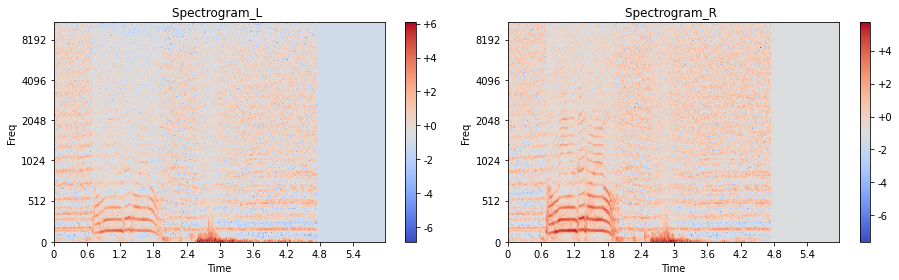

[[ 0.25627816 -4.42168639 -0.05941677 ... -1.         -1.
  -1.        ]
 [ 0.361394   -1.97175197  0.57309588 ... -1.         -1.
  -1.        ]
 [ 0.52947686 -0.69675217  1.03638156 ... -1.         -1.
  -1.        ]
 ...
 [ 0.5474403   0.31409783 -2.43451715 ... -1.         -1.
  -1.        ]
 [ 0.47406154 -1.56282989 -1.42242968 ... -1.         -1.
  -1.        ]
 [-0.45141886 -0.51166172 -0.02090219 ... -1.         -1.
  -1.        ]]


In [5]:

i = 200
Freq = 16000

x_data_L = x_data[i-1][0][:,:]
x_data_R = x_data[i-1][1][:,:]
print(y_data[i-1]*20)


plt.figure(figsize=(13,4))

plt.subplot(121)
librosa.display.specshow(x_data_L, sr=Freq, hop_length=250, x_axis='time', y_axis='mel')
plt.xlabel('Time')
plt.ylabel('Freq')
plt.colorbar(format="%+2.0f")
plt.title('Spectrogram_L ')

plt.subplot(122)
librosa.display.specshow(x_data_R, sr=Freq, hop_length=250, x_axis='time', y_axis='mel')
plt.xlabel('Time')
plt.ylabel('Freq')
plt.colorbar(format="%+2.0f")
plt.title('Spectrogram_R ')


plt.tight_layout()
plt.show()

print(x_data_L)

In [6]:


train_size = 800
valid_size = 200

x_data = torch.from_numpy( x_data ).float().to(device)
y_data = torch.from_numpy( y_data ).long().to(device).reshape(1000,)

full_dataset = TensorDataset( x_data, y_data )


train_data, valid_data = torch.utils.data.random_split( full_dataset, [train_size, valid_size] )
train_dataset = DataLoader( dataset=train_data, batch_size = BATCH_SIZE, shuffle=True, drop_last=True )
valid_dataset = DataLoader( dataset=valid_data, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)



In [7]:
import re
import torch.nn as nn
import torch.nn.functional as F



class CNN (nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        ''' 4 * 257 * 382'''
        self.conv1 = nn.Conv2d( in_channels=  4, out_channels= 64, kernel_size = (7,7), stride = (2,2) )
        #relu
        #pooling
        
        ''' 64 * 62 * 94'''
        self.conv2 = nn.Conv2d( in_channels= 64, out_channels= 64, kernel_size = (3,3) )
        #relu
        #pooling

        ''' 64 * 30 * 46'''
        self.conv3 = nn.Conv2d( in_channels= 64, out_channels= 32, kernel_size = (3,3) )
        #relu
        #pooling

        ''' 32 * 14 * 22'''
        #flatten

        self.lay1  = nn.Linear( 32*14*22, 256)
        self.lay2  = nn.Linear( 256, 256 )
        self.lay3  = nn.Linear( 256, 64 )
        self.lay4  = nn.Linear( 64 , 11 )
        


        
    def forward(self, output):
        output = F.max_pool2d( F.relu( self.conv1(output) ),2 )
        output = F.max_pool2d( F.relu( self.conv2(output) ),2 )
        output = F.max_pool2d( F.relu( self.conv3(output) ),2 )
        
        output = output.view(-1, 32*14*22)
        
        output = F.relu( self.lay1(output) )
        output = F.dropout(output, training=self.training)
        output = F.relu( self.lay2(output) )
        output = F.dropout(output, training=self.training)
        output = F.relu( self.lay3(output) )
        output = F.dropout(output, training=self.training)
        output = F.log_softmax(self.lay4(output), dim=1)
        
        return output
    

In [8]:

model = CNN().to(device)
model


CNN(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (lay1): Linear(in_features=9856, out_features=256, bias=True)
  (lay2): Linear(in_features=256, out_features=256, bias=True)
  (lay3): Linear(in_features=256, out_features=64, bias=True)
  (lay4): Linear(in_features=64, out_features=11, bias=True)
)

In [9]:


torch.manual_seed(100)
criterion = nn.CrossEntropyLoss().to(device)


'''optimizer'''
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
TITLE = 'Adam'




train_loss = []
train_acc  = []


# confusion matrix를 만들기 위해서 
# 먼저 int type의 random값이 있는 
# (1,) size torch tensor 초기화
torch_pred  = torch.empty((1,), dtype=torch.int32).to(device)
torch_label = torch.empty((1,), dtype=torch.int32).to(device)



model.train()
for epoch in range(EPOCHS):
    #print('epoch ' + str(epoch+1))
    total_loss = 0.0
    total_acc = 0
    
    
    for i, (data, label) in enumerate(train_dataset):
        (data, label) = (data.to(device), label.to(device))

        #zero the parameter gradients
        optimizer.zero_grad()        

        # forward + backward = optimize
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        

        """loss, accuracy"""
        # batch 정확도
        preds  = torch.max(output.data, 1)[1]
        corr  = (preds==label).sum().item()
        acc   = corr/BATCH_SIZE*100

        # epoch 손실도, 정확도
        total_loss += loss.item()
        total_acc += corr
    
        # batch 손실도, 정확도 출력, 저장
        #train_loss.append(loss)
        #train_acc.append(acc)


        """ confusion matrix"""
        # 마지막 epoch에서 
        if epoch == EPOCHS-1:
            torch_pred  = torch.cat( [ torch_pred , preds.to( device, dtype=torch.int32) ], dim=0 )
            torch_label = torch.cat( [ torch_label, label.to( device, dtype=torch.int32) ], dim=0 )


    train_loss.append(loss)
    train_acc.append(acc)

    # epoch 손실도, 정확도 출력
    if (epoch) % 10 == 9:
        print('epoch' + str(epoch+1) + '  >> Loss: {:.3f} \tAcc: {:.3f}'.format( total_loss, total_acc/800*100 ))
    #print()


epoch10  >> Loss: 95.845 	Acc: 9.625
epoch20  >> Loss: 93.504 	Acc: 14.875
epoch30  >> Loss: 69.700 	Acc: 29.875
epoch40  >> Loss: 52.310 	Acc: 46.500
epoch50  >> Loss: 40.129 	Acc: 57.250
epoch60  >> Loss: 30.890 	Acc: 67.000
epoch70  >> Loss: 26.667 	Acc: 72.375
epoch80  >> Loss: 19.469 	Acc: 79.750
epoch90  >> Loss: 15.262 	Acc: 87.250
epoch100  >> Loss: 11.576 	Acc: 89.500
epoch110  >> Loss: 6.900 	Acc: 94.375
epoch120  >> Loss: 7.378 	Acc: 94.000
epoch130  >> Loss: 7.216 	Acc: 94.125
epoch140  >> Loss: 5.307 	Acc: 96.250
epoch150  >> Loss: 6.235 	Acc: 94.875
epoch160  >> Loss: 4.218 	Acc: 96.125
epoch170  >> Loss: 2.973 	Acc: 97.875
epoch180  >> Loss: 3.619 	Acc: 97.375
epoch190  >> Loss: 3.482 	Acc: 97.625
epoch200  >> Loss: 2.945 	Acc: 97.375


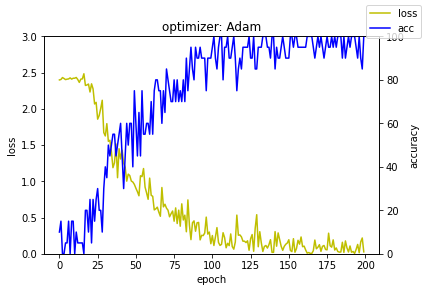

In [10]:

%matplotlib inline
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(np.asarray(train_loss), 'y')
acc_ax.plot( np.asarray(train_acc),  'b')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.set_ylim([0, 3])

acc_ax.set_ylabel('accuracy')
acc_ax.set_ylim([0, 100])


fig.legend(['loss','acc'], loc='upper right')
plt.title('optimizer: '+TITLE)
plt.savefig(PATH+TITLE+str(NUM)+'.png')
plt.show()

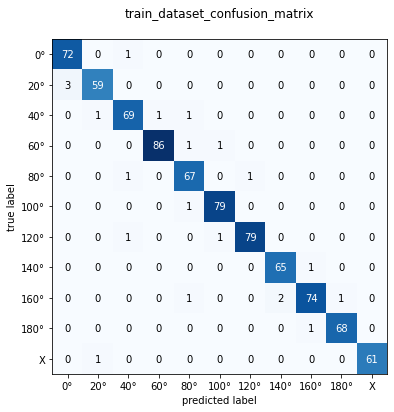

In [11]:
 

 axis = ['0\u00b0','20\u00b0','40\u00b0','60\u00b0','80\u00b0','100\u00b0','120\u00b0','140\u00b0','160\u00b0','180\u00b0','X']


# confusion matrix
# int type의 random한 값을 제외한 값들로 confusion matrix 만듦
stacked = torch.stack( ( torch_label[1:], torch_pred[1:] ), dim=1 )
cmt = torch.zeros(11,11, dtype=torch.int32)

for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] += 1


plot_confusion_matrix(cmt.numpy())
plt.title('train_dataset_confusion_matrix')

plt.xticks(np.arange(11), axis)
plt.yticks(np.arange(11), axis)
plt.gcf().set_size_inches(6,7,forward=True)

plt.savefig( PATH + 'train_dataset_confusion_matrix' + str(NUM) + '.png' )
plt.show()



In [12]:
model.eval().to(device)



with torch.no_grad():
    correct = 0
    total = 0

    #confusion matrix
    torch_pred_valid  = torch.empty((1,), dtype=torch.int32).to(device)
    torch_label_valid = torch.empty((1,), dtype=torch.int32).to(device)

    for data, label in valid_dataset:
        output = model(data)
        preds  = torch.max(output.data, 1)[1]
        total += len(label)
        correct += (preds==label).sum().item()

        #confusion matrix
        torch_pred_valid  = torch.cat( [ torch_pred_valid , preds.to( device, dtype=torch.int32) ], dim=0 )
        torch_label_valid = torch.cat( [ torch_label_valid, label.to( device, dtype=torch.int32) ], dim=0 )


    valid_stacked = torch.stack( ( torch_label_valid[1:], torch_pred_valid[1:] ), dim=1 )

      
    print('Test Accuracy: ', 100.*correct/total)



Test Accuracy:  45.0


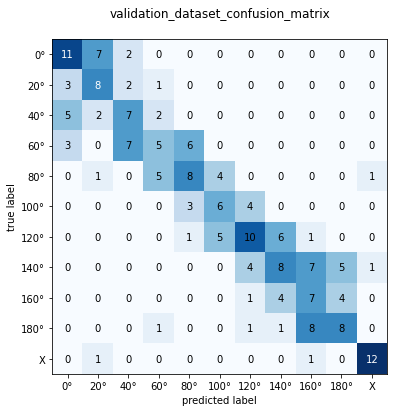

In [13]:

cmt_valid = torch.zeros(11,11, dtype=torch.int32)

for p in valid_stacked:
    tl, pl = p.tolist()
    cmt_valid[tl, pl] += 1


plot_confusion_matrix(cmt_valid.numpy())

plt.title('validation_dataset_confusion_matrix')
plt.xticks(np.arange(11), axis)
plt.yticks(np.arange(11), axis)
plt.gcf().set_size_inches(6,7,forward=True)


plt.savefig( PATH + 'validation_dataset_confusion_matrix' + str(NUM) + '.png' )
plt.show()
